<a href="https://colab.research.google.com/github/devCat404/python_projects/blob/main/BD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# step1. 데이터 정의 및 데이터 수집&가공 단계
import pandas as pd
import chardet

# 0. 파일 경로 정의
base_rate_path = "/base_rate.csv"                  # 기준금리
house_price_path = "/house_price_avg.csv"          # 평균 주택가격
income_path = "/income_per_year.csv"               # 연간 소득
interest_rate_path = "/interest_rate.csv"          # 주담대 금리
marriage_path = "/mariage_per_year.csv"            # 혼인 건수
marriage_age_path = "/marriage_age_rate.csv"       # 혼인 연령
pir_path = "/pir.csv"                              # pir 데이터

years = list(range(2019, 2025))

# 1. 데이터 불러오기
base_rate_df = pd.read_csv(base_rate_path, encoding='utf-8-sig')
house_price_df = pd.read_csv(house_price_path, encoding='utf-8-sig')
income_df = pd.read_csv(income_path, encoding='utf-8-sig')
interest_rate_df = pd.read_csv(interest_rate_path, encoding='cp949')
marriage_df = pd.read_csv(marriage_path, encoding='utf-8-sig')

with open(marriage_age_path, 'rb') as f:
    enc = chardet.detect(f.read())['encoding']
marriage_age_df = pd.read_csv(marriage_age_path, encoding=enc)

# 2. 기준금리 처리
base_rate_long = base_rate_df.melt(
    id_vars=['통계표', '계정항목', '단위', '변환'],
    var_name='연도', value_name='기준금리'
)
base_rate_long['연도'] = base_rate_long['연도'].astype(int)
base_rate_long = base_rate_long[base_rate_long['연도'].isin(years)][['연도', '기준금리']]

# 3. 주담대금리 처리 (연도별 평균)
loan_rate = interest_rate_df.iloc[0, 1:]
annual_rates = loan_rate.groupby(loan_rate.index.str[:4]).mean().reset_index()
annual_rates.columns = ['연도', '주담대금리']
annual_rates['연도'] = annual_rates['연도'].astype(int)
annual_rates = annual_rates[annual_rates['연도'].isin(years)]

# 4. 평균소득 처리
income_row = income_df[
    (income_df['행정구역별'] == '전국') &
    (income_df['자산, 부채, 소득 분류별'].str.contains('경상소득'))
]
income_long = income_row.melt(
    id_vars=['행정구역별', '자산, 부채, 소득 분류별'],
    var_name='연도', value_name='평균소득'
)[['연도', '평균소득']]
income_long['연도'] = income_long['연도'].astype(int)
income_long = income_long[income_long['연도'].isin(years)]
income_long['평균소득'] *= 10000  # 만원 → 원

# 5. 평균주택가격 처리
house_nation = house_price_df[house_price_df['행정구역별'] == '전국'].drop(columns=['행정구역별'])
house_nation.columns = pd.to_datetime(house_nation.columns, format="%Y.%m")
house_nation_by_year = house_nation.T.groupby(lambda x: x.year).mean().reset_index()
house_nation_by_year.columns = ['연도', '평균주택가격']
house_nation_by_year = house_nation_by_year[house_nation_by_year['연도'].isin(years)]

# 6. 혼인건수 처리
marriage_df = marriage_df[marriage_df['지역'] == '전국'][['연도', '혼인건수']]

# 7. 외부 PIR 데이터 불러오기
pir_df = pd.read_csv(pir_path)
nation_pir = pir_df[pir_df['지역'].str.contains('전체|전국')].iloc[0]
pir_long = pd.DataFrame({
    '연도': list(range(2019, 2025)),
    'PIR': [nation_pir[str(year)] for year in range(2019, 2025)]
})

# 8. 통합 테이블 생성 (외부 PIR 사용)
final_df = base_rate_long \
    .merge(annual_rates, on='연도') \
    .merge(income_long, on='연도') \
    .merge(house_nation_by_year, on='연도') \
    .merge(marriage_df, on='연도') \
    .merge(pir_long, on='연도')

# 9. 확인
print(final_df)


     연도  기준금리   주담대금리      평균소득      평균주택가격    혼인건수  PIR
0  2019  1.25  3.4475  58640000   90.016667  239159  5.4
1  2020  0.50     2.8  59660000   92.575000  213502  5.5
2  2021  1.00  2.8825  61800000  100.450000  192507  6.7
3  2022  3.25   4.295  64700000  103.866667  191690  6.3
4  2023  3.50    5.19  67620000   96.250000  193657  6.3
5  2024  3.00   4.725  71850000   96.025000  222412  6.3


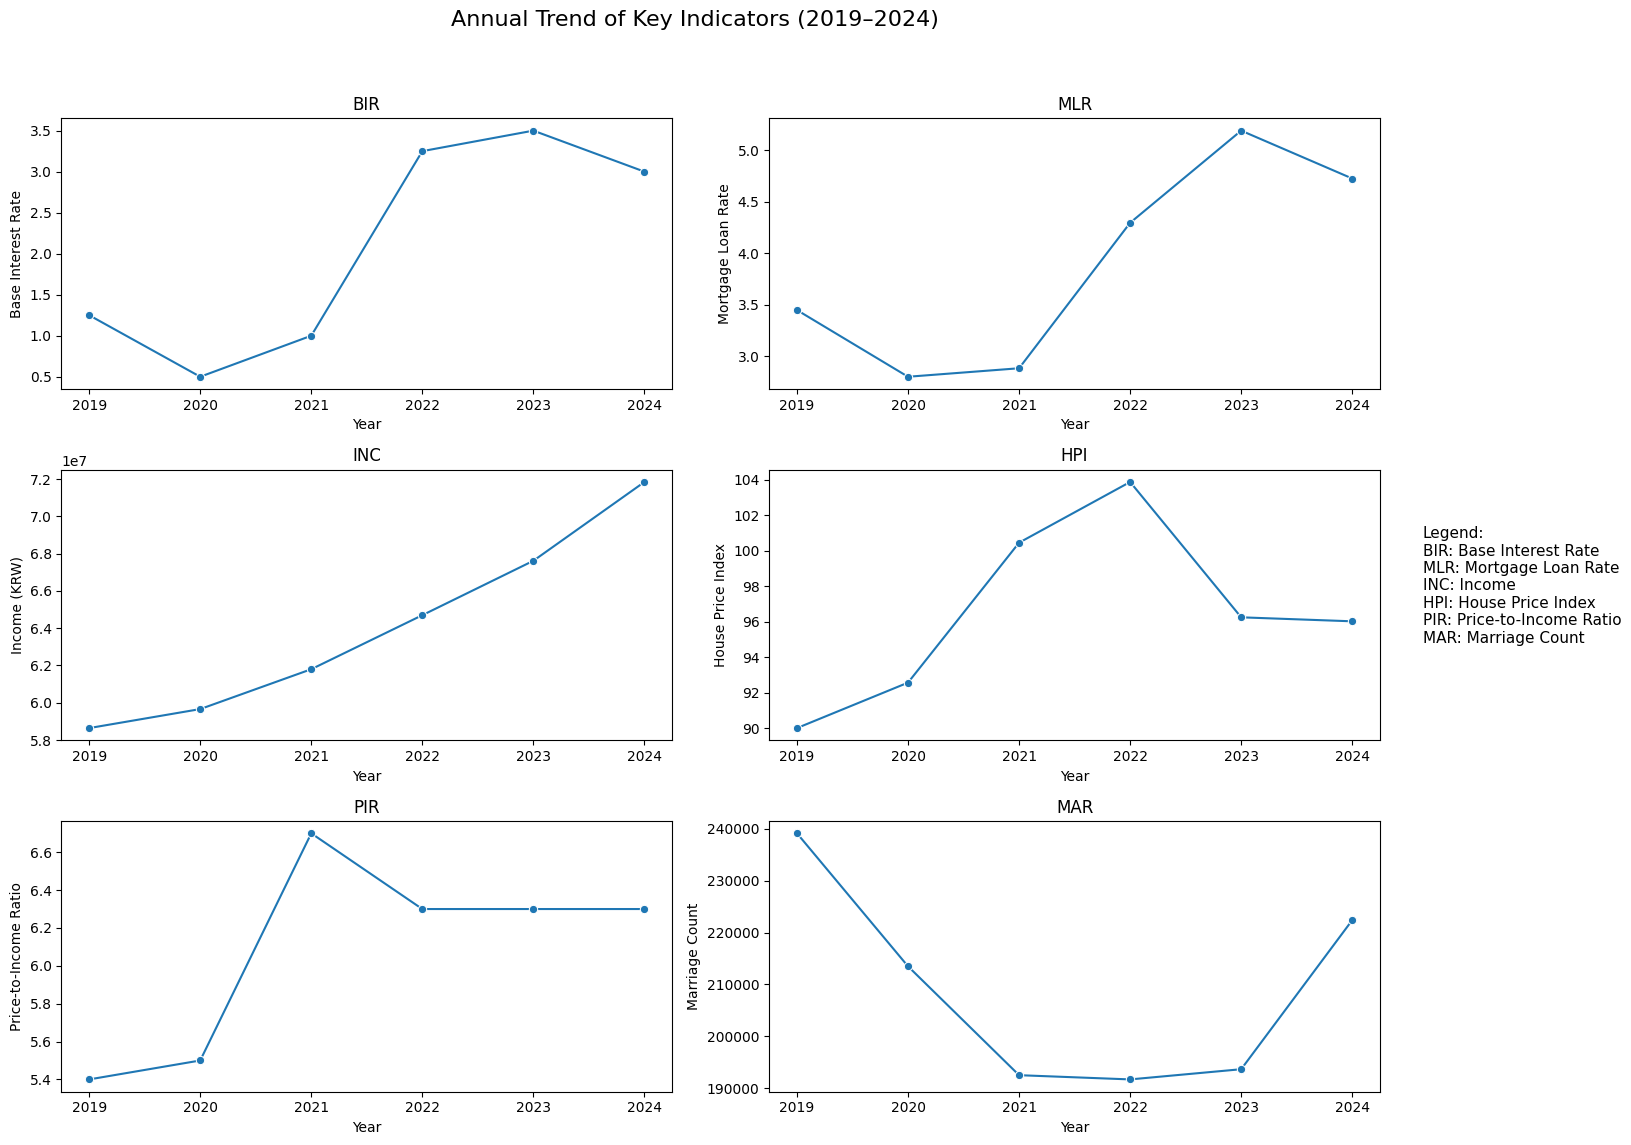

In [12]:
# step 2. 데이터 분석(EDA) 및 시각화 단계 - 관계 그래프 생성
import matplotlib.pyplot as plt
import seaborn as sns

# 약어 딕셔너리 생성
abbr_map = {
    'BIR': 'Base Interest Rate',
    'MLR': 'Mortgage Loan Rate',
    'INC': 'Income',
    'HPI': 'House Price Index',
    'PIR': 'Price-to-Income Ratio',
    'MAR': 'Marriage Count'
}

# 제목 생성
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Annual Trend of Key Indicators (2019–2024)', fontsize=16)

# 각 subplot
sns.lineplot(data=final_df, x='연도', y='기준금리', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('BIR')
axes[0, 0].set_ylabel('Base Interest Rate')
axes[0, 0].set_xlabel('Year')

sns.lineplot(data=final_df, x='연도', y='주담대금리', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('MLR')
axes[0, 1].set_ylabel('Mortgage Loan Rate')
axes[0, 1].set_xlabel('Year')

sns.lineplot(data=final_df, x='연도', y='평균소득', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('INC')
axes[1, 0].set_ylabel('Income (KRW)')
axes[1, 0].set_xlabel('Year')

sns.lineplot(data=final_df, x='연도', y='평균주택가격', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('HPI')
axes[1, 1].set_ylabel('House Price Index')
axes[1, 1].set_xlabel('Year')

sns.lineplot(data=final_df, x='연도', y='PIR', marker='o', ax=axes[2, 0])
axes[2, 0].set_title('PIR')
axes[2, 0].set_ylabel('Price-to-Income Ratio')
axes[2, 0].set_xlabel('Year')

sns.lineplot(data=final_df, x='연도', y='혼인건수', marker='o', ax=axes[2, 1])
axes[2, 1].set_title('MAR')
axes[2, 1].set_ylabel('Marriage Count')
axes[2, 1].set_xlabel('Year')

# 범례
legend_text_eng = '\n'.join([f'{k}: {v}' for k, v in abbr_map.items()])
fig.text(1.02, 0.5, f'Legend:\n{legend_text_eng}', fontsize=11, va='center')

# plot 보여주기
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

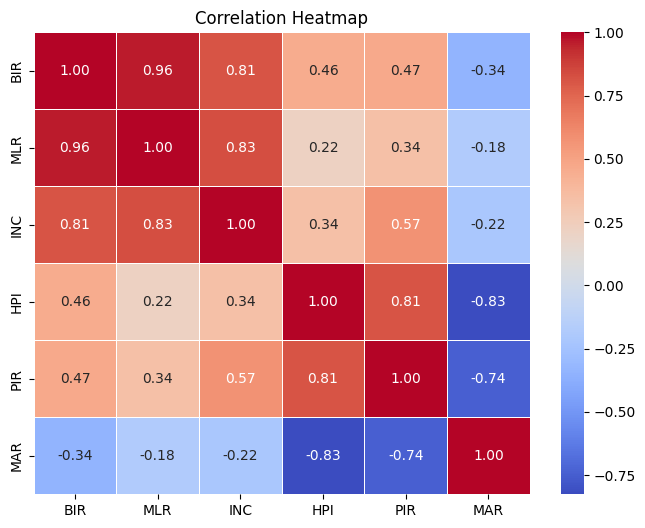

In [13]:
# step 2. 데이터 분석(EDA) 및 시각화 단계 - 상관관계 히트맵

import numpy as np

# 먼저 상관계수 행렬 계산 (관측된 수치형 변수만)
corr_df = final_df[['기준금리', '주담대금리', '평균소득', '평균주택가격', 'PIR', '혼인건수']]
corr_df.columns = ['BIR', 'MLR', 'INC', 'HPI', 'PIR', 'MAR']
corr_matrix = corr_df.corr()

# 시각화 - 상관관계 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [19]:
# step 3. 모델링 및 2025년도 예측 단계 (1. 릿지 회귀 적용)
from sklearn.linear_model import Ridge
import numpy as np

# 1. 입력 특성과 타깃값 구성
X_ridge = final_df[['기준금리', '주담대금리', 'PIR']].astype(float).to_numpy()
y_ridge = final_df['혼인건수'].astype(float).to_numpy()

# 2. Ridge 회귀 모델링
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_ridge, y_ridge)

# 3. 2025년 예측용 입력값 정의
X_2025_input = np.array([[2.75, 4.17, 7.12]])  # [기준금리, 주담대금리, PIR]

# 4. 예측
y_2025_ridge_pred = ridge_model.predict(X_2025_input)[0]
print(f"2025년도 혼인건수 예측: {round(y_2025_ridge_pred)} (건)")

2025년도 혼인건수 예측: 191784 (건)


In [20]:
# step 3. 모델링 및 2025년도 예측 단계 (2. 랜덤포레스트 회귀 적용)
from sklearn.ensemble import RandomForestRegressor

# 1. 입력 데이터 구성 (기준금리, 주담대금리, PIR)
X_rf = final_df[['기준금리', '주담대금리', 'PIR']].astype(float).to_numpy()
y_rf = final_df['혼인건수'].astype(float).to_numpy()

# 2. 랜덤 포레스트 모델 정의 및 훈련
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

# 3. 2025년 입력값 구성 및 예측
X_2025_rf = np.array([[2.75, 4.17, 7.12]])
y_2025_rf_pred = rf_model.predict(X_2025_rf)[0]

print(f"2025년도 혼인건수 예측: {round(y_2025_rf_pred)} (건)")

2025년도 혼인건수 예측: 203261 (건)


<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-8275ac27dc87>:24: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython

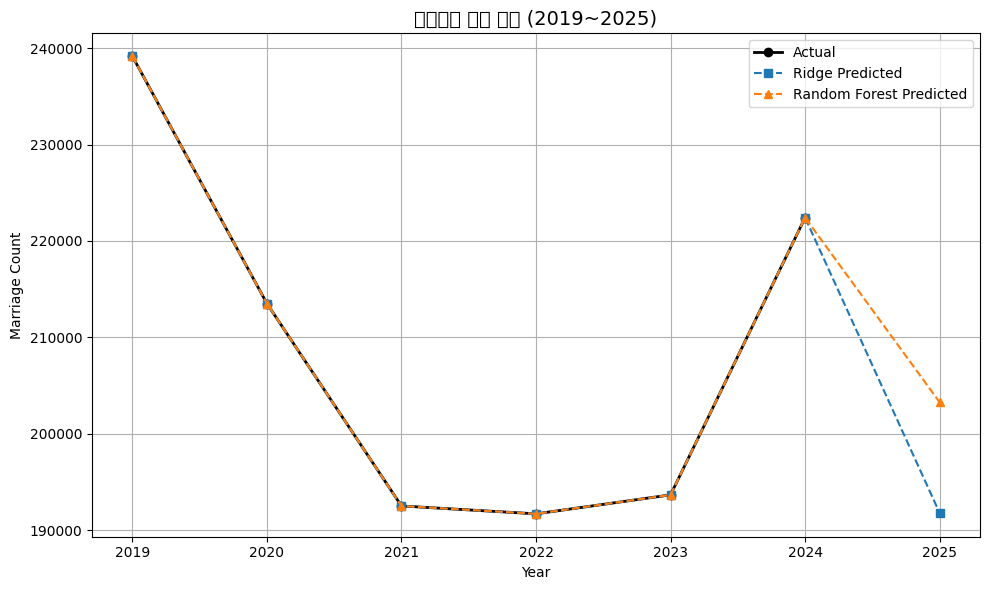

In [24]:
# step 3-2. 두 가지 모델 비교 분석

# 1. 실제 혼인건수 및 연도 목록 정의
years = final_df['연도'].tolist()
actual = final_df['혼인건수'].tolist()

# 2. 2025년 예측값을 추가한 연도 및 예측 목록 생성
years_with_2025 = years + [2025]
ridge_pred = actual + [round(y_2025_ridge_pred)]     # Ridge 예측 결과
rf_pred = actual + [round(y_2025_rf_pred)]           # RandomForest 예측 결과

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(years, actual, label='Actual', marker='o', linewidth=2, color='black')
plt.plot(years_with_2025, ridge_pred, label='Ridge Predicted', marker='s', linestyle='--')
plt.plot(years_with_2025, rf_pred, label='Random Forest Predicted', marker='^', linestyle='--')

plt.title('혼인건수 예측 비교 (2019~2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Marriage Count')
plt.xticks(years_with_2025)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()